<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_DICOM_V12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Create Custom Function

In [ ]:
# Simple function to print out elapsed time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Download and Extract Data

In [ ]:
from pathlib import Path
import requests
import zipfile
import sys
import shutil
import os
import warnings


# ------------------------------------------------------------------
# Configuration – change only if you want a different URL / filename
# ------------------------------------------------------------------
URL = "https://biologicslab.co/BIO1173/data/"
ZIP_FILENAME = "pna_data.zip"

# ------------------------------------------------------------------
# Download the zip file (streamed, so it works with large files)
# ------------------------------------------------------------------
def download_zip(url: str, dest: Path, chunk_size: int = 8192) -> None:
    """Download a file from `url` and write it to `dest`."""
    print(f"Downloading {ZIP_FILENAME} to {dest}...", end='')
    with requests.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()           # will raise for 4xx/5xx
        with dest.open("wb") as f_out:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:               # filter out keep‑alive new chunks
                    f_out.write(chunk)
    print("done")

# ------------------------------------------------------------------
# Un‑zip the downloaded archive into a *named* directory
# ------------------------------------------------------------------
def unzip_file(zip_path: Path, extract_to: Path) -> None:
    """Extract all members of `zip_path` into `extract_to`."""
    print(f"Unzipping {ZIP_FILENAME} to {extract_to}...", end='')
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_to)
    print("done")

# ------------------------------------------------------------------
# Optional – delete the zip after extraction
# ------------------------------------------------------------------
def clean_up_zip(zip_path: Path) -> None:
    """Delete the zip file – only if you no longer need it."""
    zip_path.unlink()
    print(f"Removed temporary archive: {zip_path}... done")

# ------------------------------------------------------------------
# Main routine
# ------------------------------------------------------------------
def main() -> None:
    cwd          = Path.cwd()            # current working directory
    zip_path     = cwd / ZIP_FILENAME
    extract_dir  = cwd / zip_path.stem   # e.g. /pna_data

    # Ensure the extraction directory exists
    extract_dir.mkdir(parents=True, exist_ok=True)

    # Download
    download_zip(URL+ZIP_FILENAME, zip_path)

    # Un‑zip
    unzip_file(zip_path, extract_dir)

    # Clean‑up the downloaded archive
    clean_up_zip(zip_path)

    print(f"Files have been extracted to {extract_dir}")

# ------------------------------------------------------------------
if __name__ == "__main__":
    main()


Unzipping pna_data.zip to /content/pna_data...done
Removed temporary archive: /content/pna_data.zip... done
Files have been extracted to /content/pna_data


### Import Packages

In [ ]:
!pip install -q pydicom
!pip install -q dropblock

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.8 MB/s eta 0:00:00


### Process DICOM Files

In [ ]:
# Process DICOM Files

import numpy as np
import pandas as pd
import pydicom
import warnings
from matplotlib import pyplot as plt

# Global settings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------
#  Helper: read a single DICOM file
# -------------------------------------------------------------
def read_dicom_file(file_path: str):
    """Read a DICOM file and extract image data + basic metadata."""
    ds = pydicom.dcmread(file_path)

    # Basic metadata
    metadata = {
        'filename': os.path.basename(file_path),
        'patient_name': getattr(ds, 'PatientName', 'Unknown'),
        'patient_id': getattr(ds, 'PatientID', 'Unknown'),
        'study_date': getattr(ds, 'StudyDate', 'Unknown'),
        'study_time': getattr(ds, 'StudyTime', 'Unknown'),
        'modality': getattr(ds, 'Modality', 'Unknown'),
        'manufacturer': getattr(ds, 'Manufacturer', 'Unknown'),
        'institution_name': getattr(ds, 'InstitutionName', 'Unknown'),
        'series_description': getattr(ds, 'SeriesDescription', 'Unknown'),
        'bits_allocated': getattr(ds, 'BitsAllocated', 'Unknown'),
        'rows': getattr(ds, 'Rows', 'Unknown'),
        'columns': getattr(ds, 'Columns', 'Unknown'),
        'pixel_spacing': getattr(ds, 'PixelSpacing', 'Unknown')
    }

    # Image data
    if hasattr(ds, 'pixel_array'):
        image_array = ds.pixel_array

        # Normalise to 0‑255 if needed
        if image_array.dtype != np.uint8:
            image_array = ((image_array - image_array.min()) /
                           (image_array.max() - image_array.min()) * 255).astype(np.uint8)

        metadata['image_available'] = True
        metadata['image_shape'] = image_array.shape
    else:
        metadata['image_available'] = False
        metadata['image_shape'] = 'No image data'

    return ds, metadata

# -------------------------------------------------------------
#  Helper: fast drop‑check
# -------------------------------------------------------------
def is_file_dropped(file_path: str) -> bool:
    """
    Quick guard that tells us whether a DICOM file is already
    missing / unreadable.
    """
    if not os.path.isfile(file_path):
        return True

    if os.path.getsize(file_path) == 0:
        return True

    try:
        pydicom.dcmread(file_path, stop_before_pixels=True)
    except Exception:
        return True

    return False

# -------------------------------------------------------------
#  Load & preprocess – merge CSVs, keep only valid DICOM rows
# -------------------------------------------------------------

import os
import pandas as pd
import pathlib

# (Assumes you already have an `is_file_dropped` helper somewhere in your code)
# from your_module import is_file_dropped   # <-- adjust import as needed

def load_and_preprocess_data(
    data_dir: str = '.',
    log_dropped: bool = True,
    max_files: int | None = None,
    seed: int = 42
):
    """
    Load the two CSVs, merge on patient ID, filter out rows that don't have a
    valid DICOM file and optionally subsample the result.

    Returns:
        image_df (pd.DataFrame):  DataFrame that contains a new column
                                 `file_path` pointing to the DICOM file
                                 and the original merged columns.
        dropped_ids (list[str]):  Patient IDs that were dropped.
    """
    # --- 1. Resolve the path & sanity‑check the CSVs ---------------------------------
    data_path   = pathlib.Path(data_dir).expanduser().resolve()
    info_csv    = data_path / 'pna_detailed_class_info.csv'
    labels_csv  = data_path / 'pna_train_labels.csv'

    for fp in (info_csv, labels_csv):
        if not fp.is_file():
            raise FileNotFoundError(
                f"Required file not found: {fp}\n"
                f"Ensure `data_dir` points to the folder containing both CSVs."
            )

    # --- 2. Load the CSVs ----------------------------------------------------------------
    info_df   = pd.read_csv(info_csv)
    labels_df = pd.read_csv(labels_csv)

    # --- 3. Merge on patient ID ---------------------------------------------------------
    info_id_col   = 'patientId'
    labels_id_col = 'patientId'

    merged_df = pd.merge(
        info_df,
        labels_df,
        left_on=info_id_col,
        right_on=labels_id_col,
        how='inner'
    )

    # --- 4. Keep only rows that actually have a readable DICOM -------------------------
    dicom_dir   = data_path / 'pna_train_images'
    valid_rows  = []
    dropped_ids = []

    for idx, row in merged_df.iterrows():
        patient_id = row[info_id_col]
        dicom_file = dicom_dir / f"{patient_id}.dcm"

        if is_file_dropped(dicom_file):
            dropped_ids.append(patient_id)
        else:
            valid_rows.append(idx)

    image_df = merged_df.loc[valid_rows].copy()
    if log_dropped:
        print(f"Dropped {len(dropped_ids)} rows (no valid DICOM).")

    # --- 5. (Optional) Random subsample ------------------------------------------------
    if max_files is not None and len(image_df) > max_files:
        image_df = image_df.sample(n=max_files, random_state=seed).reset_index(drop=True)
        if log_dropped:
            print(f"Randomly subsampled to {max_files} rows (seed={seed}).")

    # --- 6. Add `file_path` column ----------------------------------------------------
    #   This mirrors the original behaviour – the rest of the code can still
    #   reference `image_df['file_path']` exactly as before.
    image_df['file_path'] = image_df['patientId'].apply(
        lambda pid: str(dicom_dir / f"{pid}.dcm")
    )

    # print(f"Filtered DataFrame shape (with valid DICOM files): {image_df.shape}")
    return image_df, dropped_ids


# ────────────────────────────────────────────────────────────────────────────────
#  Update load_and_preprocess_data to return only file‑paths + labels
# ────────────────────────────────────────────────────────────────────────────────
def load_file_paths_and_labels(image_df, max_samples=None):
    """
    Return two lists: `file_paths` and `labels`.  The function keeps the
    *original* logic that filtered out NaNs / duplicated rows – we simply
    strip it down to the very few objects that the new lazy loader needs.
    """
    file_paths = image_df["file_path"].tolist()
    labels = image_df["label"].tolist()

    if max_samples is not None:
        file_paths = file_paths[:max_samples]
        labels = labels[:max_samples]

    return file_paths, labels

# -------------------------------------------------------------
#  Main block – run the whole pipeline
# -------------------------------------------------------------
if __name__ == "__main__":
    # Path to the data root
    data_root = os.path.join('.', 'pna_data')

### Generate img_df

In [ ]:
# Example:  keep at most 10 000 random rows (reproducible)

MAX_FILES=10000
SET_SEED=586

# generate image_df
print(f"Generating img_df with {MAX_FILES} DICOM images with seed {SET_SEED}...")
img_df, dropped = load_and_preprocess_data(
    data_dir='./pna_data',
    max_files=MAX_FILES,         # 10_000,
    seed=SET_SEED,
    log_dropped=True
)
img_df.head()

Generating img_df with 10000 DICOM images with seed 586...
Dropped 28292 rows (no valid DICOM).


,patientId,class,x,y,width,height,Target,file_path
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,/content/pna_data/pna_train_images/00313ee0-9e...
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,/content/pna_data/pna_train_images/00322d4d-1c...
18,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,288.0,322.0,94.0,135.0,1,/content/pna_data/pna_train_images/00aecb01-a1...
19,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,547.0,299.0,119.0,165.0,1,/content/pna_data/pna_train_images/00aecb01-a1...
20,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,288.0,322.0,94.0,135.0,1,/content/pna_data/pna_train_images/00aecb01-a1...


### Build Lists

In [ ]:
# Build the two lists that the rest of your pipeline expects ----
file_paths_list = img_df['file_path'].tolist()
labels_list     = img_df['Target'].astype(int).tolist()

# --- Optional: quick sanity check ----------------------------------
print(f"First file path: {file_paths_list[:1]}")
print(f"First label:     {labels_list[:1]}")


First file path: ['/content/pna_data/pna_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm']
First label:     [0]


### Create Plotting Functions



In [ ]:
# Create Plotting Functions

# -------------------------------------------------------------
#  Show a single DICOM image (for sanity checks)
# -------------------------------------------------------------
def display_dicom_image(file_path: str, figsize: tuple = (10, 10)):
    """Show a single DICOM image with proper orientation."""
    ds = pydicom.dcmread(file_path)
    if hasattr(ds, 'pixel_array'):
        img = ds.pixel_array
        if getattr(ds, 'PhotometricInterpretation', None) == 'MONOCHROME1':
            img = np.max(img) - img

        plt.figure(figsize=figsize)
        plt.imshow(img, cmap='gray')
        plt.title(ds.SOPClassUID)
        plt.axis('off')
        plt.show()
    else:
        print("This DICOM has no pixel data.")

# -------------------------------------------------------------
#  Visualise class / target distributions
# -------------------------------------------------------------
def visualize_data_distribution(image_df: pd.DataFrame):
    if image_df is None:
        return

    plt.figure(figsize=(12, 6))

    # Class distribution
    plt.subplot(1, 2, 1)
    if 'class' in image_df.columns:
        class_counts = image_df['class'].value_counts()
        class_counts.plot(kind='bar')
        plt.title('Class Distribution')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No class column found', ha='center')
        plt.title('Class Distribution')

    # Target distribution
    plt.subplot(1, 2, 2)
    if 'Target' in image_df.columns:
        target_counts = image_df['Target'].value_counts()
        target_counts.plot(kind='bar')
        plt.title('Target Distribution')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No Target column found', ha='center')
        plt.title('Target Distribution')

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt


# -------------------------------------------------------------
#  Visualise class / target distributions
# -------------------------------------------------------------
def plot_train_val(history: dict,
                   num_epochs: int,
                   batch_size: int,
                   title: str | None = None) -> None:
    """
    Plot a two‑panel figure with vertical line at the best epoch.

    Parameters
    ----------
    history : dict
        Must contain the keys 'train_acc', 'val_acc',
        'train_loss', 'val_loss'.
    num_epochs : int
        Total number of epochs that were run.
    batch_size : int
        Batch size that was used (kept for API compatibility).
    title : str | None, optional
        Figure title.  If None, a default title is used.
    """
    epochs = np.arange(1, num_epochs + 1)

    # ---- 2‑panel layout ---------------------------------------------
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(14, 5))

    # ---------- Left panel – accuracy --------------------------------
    ax_acc.plot(epochs, history["train_acc"], label="train acc", color="C0")
    ax_acc.plot(epochs, history["val_acc"],   label="val acc",   color="C1")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_ylim(0, 1)
    ax_acc.legend(loc="lower right")
    ax_acc.set_title("Accuracy")

    # ---------- Right panel – loss -----------------------------------
    ax_loss.plot(epochs, history["train_loss"], label="train loss", color="C2")
    ax_loss.plot(epochs, history["val_loss"],   label="val loss",   color="C3")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.set_ylim(bottom=0)        # let matplotlib decide the top limit
    ax_loss.legend(loc="upper right")
    ax_loss.set_title("Loss")

    # ---------- Vertical line at best epoch ------------------------
    if global_best_epoch is not None:
        # Draw the line on both axes
        for ax in (ax_acc, ax_loss):
            ax.axvline(
                global_best_epoch, color="red",
                linestyle="--", linewidth=1.5,
                label="Best epoch"
                )
        # Update legend to include the new label (only once)
        # The 'best_epoch' label is already added in the loop; we simply
        # force the legend to re‑compute.
        ax_acc.legend(loc="lower right")
        ax_loss.legend(loc="upper right")

    # ---------- Figure title ----------------------------------------
    if title is None:
        title = "Training History"
    fig.suptitle(title, fontsize=16)

    # Keep the suptitle separate from the sub‑plots
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()


### Create Data Functions

In [ ]:
# Create Data Functions

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from tqdm import tqdm
import torch.nn.functional as F
import copy
from typing import Optional

# Set Import Variables
NUM_EPOCHS: int = 50
BATCH_SIZE: int = 64  # Reduced for memory management
IMG_SIZE: int = 512  # Standard size for ResNet101
LEARNING_RATE: float = 0.0010
WEIGHT_DECAY: float  = 0.0010
VAL_SPLIT: float = 0.2
PATIENCE = 5
EARLY_STOPPING = True

# ------------------------------------------
# Custom Dataset Class with Transforms
# ------------------------------------------
class DicomImageDataset(Dataset):
    """
    Load a DICOM image from disk and return (image_tensor, label).

    Parameters
    ----------
    file_paths : list[str]
        Absolute paths to the DICOM files.
    labels    : list[int]
        Integer labels that align with `file_paths`.
    transform : callable | None
        Optional transform that receives the `pydicom.dataset.FileDataset`
        and returns a torch tensor.
    """

    def __init__(self, file_paths, labels, transform=None):
        assert len(file_paths) == len(labels), \
            f"file_paths ({len(file_paths)}) != labels ({len(labels)})"
        self.file_paths = file_paths
        self.labels    = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path  = self.file_paths[idx]
        label = self.labels[idx]

        try:
            dicom_img = pydicom.dcmread(path, force=True)   # <-- fails on corrupt files
        except Exception as exc:
            # Raise a RuntimeError that will be caught by the caller.
            raise RuntimeError(f"Could not read DICOM at {path!r}: {exc}")

        # Convert DICOM pixel array to proper format for transforms
        if hasattr(dicom_img, 'pixel_array'):
            img_array = dicom_img.pixel_array

            # Handle different data types and normalize
            if img_array.dtype != np.uint8:
                if img_array.max() > 1.0:
                    img_array = ((img_array - img_array.min()) /
                               (img_array.max() - img_array.min()) * 255).astype(np.uint8)
                else:
                    img_array = (img_array * 255).astype(np.uint8)

            # Convert to PIL Image for transforms
            from PIL import Image
            if len(img_array.shape) == 2:
                # Single channel - convert to RGB by duplicating
                pil_img = Image.fromarray(img_array, mode='L')
                # Convert grayscale to RGB
                pil_img = pil_img.convert('RGB')
            else:
                # Already multi-channel, convert to RGB if needed
                pil_img = Image.fromarray(img_array)
                if pil_img.mode != 'RGB':
                    pil_img = pil_img.convert('RGB')

            if self.transform is not None:
                img = self.transform(pil_img)
            else:
                # Convert to tensor if no transform
                img = torch.tensor(img_array, dtype=torch.float32)
                if len(img.shape) == 2:
                    img = img.unsqueeze(0)  # Add channel dimension
        else:
            raise RuntimeError(f"No pixel array in DICOM file {path!r}")

        return img, label



# ------------------------------------------
# Helper: Check file paths
# ------------------------------------------
def filter_valid_dicom(paths, labels, max_attempts=5):
    """
    Returns a pair (valid_paths, valid_labels) that only contains files that
    can be successfully read with pydicom.
    """
    valid_paths, valid_labels = [], []
    for p, l in zip(paths, labels):
        try:
            pydicom.dcmread(p, force=True)
        except Exception as exc:
            # Log and skip
            print(f"⚠️  Skipping {p!r}: {exc}")
            continue
        valid_paths.append(p)
        valid_labels.append(l)

    if not valid_paths:
        raise RuntimeError("All DICOM files failed to load – dataset is empty.")
    return valid_paths, valid_labels

# ------------------------------------------
# Helper: Build transforms
# ------------------------------------------
def get_transform(
    img_size=IMG_SIZE,
    is_train: bool = True,
    crop_size=IMG_SIZE,
    h_flip: bool = True,
    augment: bool = False
) -> transforms.Compose:
    """
    Returns a torchvision transform chain.
    """
    if is_train:
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomResizedCrop(crop_size) if augment else transforms.CenterCrop(crop_size),
            transforms.RandomHorizontalFlip() if h_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),  # This will convert to float and normalize [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    else:  # eval / test
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    return transform


# ------------------------------------------------------------------
# Helper: build loaders from lazy datasets
# ------------------------------------------------------------------
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet101_Weights
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import gc

def build_loaders(
    file_paths, labels,
    batch_size: int = BATCH_SIZE,
    val_split:  float = VAL_SPLIT,
    num_workers: int = 0,
    pin_memory: bool = False
):
    """Create train/validation DataLoaders from lazy dataset."""
    transform_train = get_transform(is_train=True)
    transform_val   = get_transform(is_train=False)

    full_dataset = DicomImageDataset(file_paths, labels, transform=transform_train)

    train_size = int(len(full_dataset) * (1.0 - val_split))
    val_size   = len(full_dataset) - train_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

    # Override validation transform
    val_ds.dataset.transform = transform_val

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory
    )
    return train_loader, val_loader

# ------------------------------------------
# Training loop
# ------------------------------------------
from tqdm import tqdm

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    model_name: str | None = None,          # NEW
) -> float:
    """
    Train a single epoch.  The new ``model_name`` argument is *only* for
    bookkeeping – it is stored on the model as ``model.name``.
    """
    if model_name is not None:
        # Store the name for later inspection
        model.name = model_name

    model.train()
    epoch_loss = 0.0

    for imgs, targets in tqdm(loader, desc="Training", leave=False):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * imgs.size(0)

    return epoch_loss / len(loader.dataset)


# --------------------------------------------
# Measure validation loss during training
# --------------------------------------------
def validate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> tuple[float, float]:
    model.eval()
    epoch_loss = 0.0
    correct = 0

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Validation", leave=False):
            imgs, targets = imgs.to(device), targets.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()

    val_loss = epoch_loss / len(loader.dataset)
    val_acc = correct / len(loader.dataset)
    return val_loss, val_acc

import torch
import torch.nn as nn
from torchvision import models
from dropblock import DropBlock2D  # pip install dropblock

def get_resnet101(
    num_classes: int,
    pretrained: bool = True,
    device: torch.device | None = None,
    name: str | None = None,
    dropout_p: float = 0.5,
    dropblock_size: int | None = 5,
    dropblock_prob: float | None = 0.1,
    add_norm: bool = False,
    **kwargs,
) -> nn.Module:
    """
    Return a ResNet‑101 backbone followed by optional regularisers
    and a final linear head.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    pretrained : bool, default=True
        Load ImageNet pre‑trained weights.
    device : torch.device | None, default=None
        Device to move the model onto.
    name : str | None, default=None
        Optional human‑friendly name (`model.name = name`).
    dropout_p : float, default=0.5
        Drop‑out probability *after* the backbone.
    dropblock_size : int | None, default=5
        Size of the spatial block to drop (used only if dropblock_prob > 0).
    dropblock_prob : float | None, default=0.1
        Probability that a block is dropped.
    add_norm : bool, default=False
        Add a 1‑D BatchNorm layer *after* the backbone.

    Returns
    -------
    nn.Module
        Sequential model: `backbone → (optional layers) → Linear`
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre‑trained ResNet‑101
    backbone = models.resnet101(
        weights=models.ResNet101_Weights.DEFAULT if pretrained else None
    )

    # Insert DropBlock *before* the global avg‑pool
    if dropblock_size is not None and dropblock_prob is not None:
        # The final residual block produces a 4‑D tensor (b, 2048, 7, 7)
        backbone.layer4 = nn.Sequential(
            backbone.layer4,
            DropBlock2D(block_size=dropblock_size, drop_prob=dropblock_prob)
        )

    # Make the backbone output a 1‑D vector (2048‑dim)
    in_features = backbone.fc.in_features
    backbone.fc = nn.Identity()

    # Build the tail
    layers: list[nn.Module] = [backbone]

    if add_norm:
        layers.append(nn.BatchNorm1d(in_features))

    if dropout_p > 0.0:
        layers.append(nn.Dropout(p=dropout_p))

    # Final classification head
    layers.append(nn.Linear(in_features, num_classes))

    # Stack everything
    model = nn.Sequential(*layers).to(device)

    if name is not None:
        model.name = name

    return model


# ------------------------------------------
# Training routine
# ------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import models
import copy, gc

# 1. Declare a global variable at module level
global_best_epoch = None

def run_training_lazy(
    file_paths: list[str],
    labels:     list[int],
    num_epochs: int   = NUM_EPOCHS,
    batch_size: int   = BATCH_SIZE,
    lr:          float = LEARNING_RATE,
    weight_decay:float = WEIGHT_DECAY,
    patience:    int   = PATIENCE,
    val_split:   float = VAL_SPLIT,
    early_stop:  bool  = EARLY_STOPPING,
    device:      torch.device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- Loaders
    train_loader, val_loader = build_loaders(
        file_paths, labels,
        batch_size=batch_size,
        val_split=val_split,
        num_workers=0,
        pin_memory=False
    )

    # ----- Model
    num_classes = max(labels) + 1
    # model = get_resnet101(num_classes=num_classes, pretrained=True, device=device)
    model = get_resnet101(
    num_classes=10,
    pretrained=True,
    dropout_p=0.5,
    dropblock_size=5,
    dropblock_prob=0.1,
    add_norm=True,
    name="resnet101_reg"
)

    # ----- Loss/optimiser/scheduler
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    #optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=lr * 0.01
    )

    # ----- Early‑stopping bookkeeping
    best_val_loss = float("inf")
    best_epoch = 0
    best_train_acc = best_val_acc = None
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improve = 0

    # ----- History
    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    # ----- Epoch loop
    for epoch in range(1, num_epochs + 1):
        # training
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        n_train = len(train_loader.dataset)

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == yb).sum().item()

        epoch_train_loss /= n_train
        epoch_train_acc  = correct_train / n_train

        # validation
        model.eval()
        epoch_val_loss = 0.0
        correct_val = 0
        n_val = len(val_loader.dataset)

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                epoch_val_loss += loss.item() * xb.size(0)
                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == yb).sum().item()

        epoch_val_loss /= n_val
        epoch_val_acc  = correct_val / n_val

        # scheduler step
        scheduler.step()

        # early stopping
        if early_stop:
            if epoch_val_loss < best_val_loss - 1e-5:
                best_val_loss = epoch_val_loss
                best_epoch = epoch
                best_train_acc = epoch_train_acc
                best_val_acc   = epoch_val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_without_improve = 0
            else:
                epochs_without_improve += 1

            if epochs_without_improve >= patience:
                print("\nEarly stopping triggered.")
                print(f"Best epoch (before stopping): {best_epoch}")
                print(f"  Train Acc: {best_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f}")
                print(f"  Valid Acc: {best_val_acc:.4f} | Valid Loss: {epoch_val_loss:.4f}\n")
                model.load_state_dict(best_model_wts)
                break

        # log
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Acc:  {epoch_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f} | "
            f"Val Acc:    {epoch_val_acc:.4f} | Val Loss: {epoch_val_loss:.4f}"
        )

        # history
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

    # final report
    if not early_stop or epochs_without_improve < patience:
        best_epoch = epoch
        best_train_acc = epoch_train_acc
        best_val_acc   = epoch_val_acc
        best_val_loss  = epoch_val_loss

    print("\nTraining finished.")
    print(f"Best epoch: {best_epoch}")
    print(f"  Train Acc: {best_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val   Acc: {best_val_acc:.4f}   | Val   Loss: {epoch_val_loss:.4f}")

    torch.cuda.empty_cache()
    gc.collect()

    # Store best_epoch globally
    global global_best_epoch
    global_best_epoch = best_epoch

    return {
        "train_loss": train_losses,
        "train_acc":   train_accs,
        "val_loss":    val_losses,
        "val_acc":     val_accs,
        "best_epoch":  best_epoch,
        "best_train_acc": best_train_acc,
        "best_val_acc":   best_val_acc,
        "best_train_loss": epoch_train_loss,
        "best_val_loss":   epoch_val_loss,
    }

### Setup Device

In [ ]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Get File Paths to Data

In [ ]:
# Get file paths to data
file_paths_list = img_df["file_path"].tolist()
labels_list     = img_df["Target"].astype(int).tolist()

print(file_paths_list[:1])   # e.g. ['path/to/patient001.dcm', 'path/to/patient002.dcm', ...]
print(labels_list[:1])       # e.g. [0]

['/content/pna_data/pna_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm']
[0]


### Run Training

In [ ]:
# Run Training

import time

# ------------------------------------------------------------------------
# Start training
# ------------------------------------------------------------------------
print(f"-- Training (classification) is starting for {NUM_EPOCHS} epochs----------------------------")
start_time = time.time()

# Run training
history = run_training_lazy(
    file_paths=file_paths_list,
    labels=labels_list,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE,
    val_split=VAL_SPLIT,
    early_stop=EARLY_STOPPING
)

# Record end time
elapsed_time = time.time() - start_time

# Print elapsed time
print(f"Elapsed time: {hms_string(elapsed_time)}")

-- Training (classification) is starting for 50 epochs----------------------------
Epoch 1/50 | Train Acc:  0.7668 | Train Loss: 1.3391 | Val Acc:    0.7794 | Val Loss: 2.3417
Epoch 2/50 | Train Acc:  0.8543 | Train Loss: 0.9376 | Val Acc:    0.8453 | Val Loss: 1.0855
Epoch 3/50 | Train Acc:  0.8609 | Train Loss: 0.9110 | Val Acc:    0.8592 | Val Loss: 0.8931
Epoch 4/50 | Train Acc:  0.9189 | Train Loss: 0.7552 | Val Acc:    0.8769 | Val Loss: 0.9417
Epoch 5/50 | Train Acc:  0.9691 | Train Loss: 0.6313 | Val Acc:    0.9020 | Val Loss: 0.8228
Epoch 6/50 | Train Acc:  0.9926 | Train Loss: 0.5783 | Val Acc:    0.9074 | Val Loss: 0.7736
Epoch 7/50 | Train Acc:  0.9969 | Train Loss: 0.5559 | Val Acc:    0.9095 | Val Loss: 0.7601
Epoch 8/50 | Train Acc:  0.9981 | Train Loss: 0.5493 | Val Acc:    0.9122 | Val Loss: 0.7566
Epoch 9/50 | Train Acc:  0.9991 | Train Loss: 0.5388 | Val Acc:    0.9031 | Val Loss: 0.7540
Epoch 10/50 | Train Acc:  0.9989 | Train Loss: 0.5324 | Val Acc:    0.9127 | Val

In [ ]:
best_epoch = run_training_lazy(...).get("best_epoch")
print(best_epoch)

TypeError: run_training_lazy() missing 1 required positional argument: 'labels'

### Plot Train History

ValueError: x and y must have same first dimension, but have shapes (50,) and (17,)

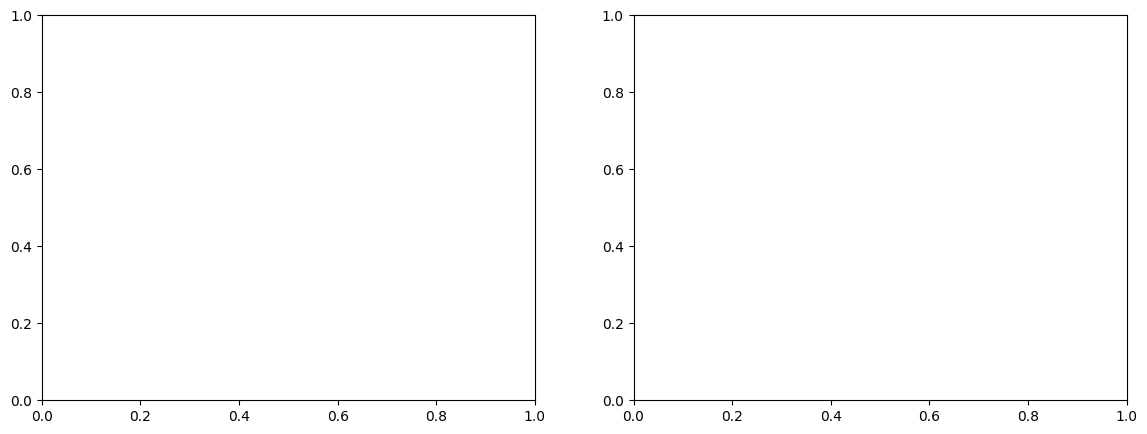

In [ ]:
#plot_train_val(history, NUM_EPOCHS, BATCH_SIZE, title="Training and Validation")
plot_train_val(history=history,
               num_epochs=NUM_EPOCHS,
               batch_size=BATCH_SIZE,
               #best_epoch=10,
               title="Model Performance")
